<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Google-Health/imaging-research/blob/master/cxr-foundation/CXR_Foundation_Demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Google-Health/imaging-research/blob/master/cxr-foundation/CXR_Foundation_Demo.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


# CXR Foundation Demo

This notebook demonstrates the richness of information contained in embeddings, generated from full Chest X-Ray images. The contents include how to:

- Download DICOM images and labels from the open-access NIH ChestX-ray14 dataset
- Use the CXR Foundation API to generate image embeddings from the DICOMs
- Train a simple neural network (WITHOUT needing GPU) to detect a medical finding in the embeddings

## Prerequisites

You must have access to use the CXR Foundation API. See the project's [README](https://github.com/Google-Health/imaging-research/blob/master/cxr-foundation/README.md) for details.

# Installation

Install the CXR Foundation package

In [1]:
!git clone https://github.com/Google-Health/imaging-research.git
!pip install imaging-research/cxr-foundation/

# Notebook specific dependencies
!pip install matplotlib sklearn tf-models-official>=2.13.0 google-cloud-storage

fatal: destination path 'imaging-research' already exists and is not an empty directory.
Processing ./imaging-research/cxr-foundation
  Preparing metadata (setup.py) ... done
  Created wheel for cxr-foundation: filename=cxr_foundation-1.0.0-py3-none-any.whl size=15457 sha256=af018431f7c4f8141a0adb76b31a90fb8520983913d2601b7040506bb75094b7
  Stored in directory: /root/.cache/pip/wheels/e3/b6/ad/96bdd7e06bf72401f6e27261a8c0fa7a76bf43b7c50ccfbae6
Successfully built cxr-foundation
  Attempting uninstall: cxr-foundation
    Found existing installation: cxr-foundation 1.0.0
    Uninstalling cxr-foundation-1.0.0:
      Successfully uninstalled cxr-foundation-1.0.0


**IMPORTANT**: If you are using Colab, you must restart the runtime after installing new packages.

NOTE: There will be some ERROR messages due to the protobuf library - this is normal.

# Authenticate to Access Data

The following cell is for Colab only. If running elsewhere, authenticate with the [gcloud CLI](https://cloud.google.com/sdk/gcloud/reference/auth/login).

In [2]:
from google.colab import auth

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

# Download Data

The NIH ChestX-ray14 dataset, consists of over 100,000 de-identified images of chest x-rays, with fourteen common disease labels, text-mined from the text radiological reports via NLP techniques. The dataset is available on the NIH [download site](https://nihcc.app.box.com/v/ChestXray-NIHCC) and on [Google Cloud](https://cloud.google.com/healthcare-api/docs/resources/public-datasets/nih-chest).

The CXR Foundation Demo GCS [bucket](https://console.cloud.google.com/storage/browser/cxr-foundation-demo) contains a subset of the data. We will download the dataset's labels file and some DICOM images below. This might take ~10 minutes or so depending on your connection speed.

In [3]:
import io
import os

from google.cloud import storage
import pandas as pd

# Make a directory to download the data
if not os.path.exists('data'):
  os.mkdir('data')

# Initialize the GCS storage client
storage_client = storage.Client()
bucket = storage_client.get_bucket('cxr-foundation-demo')

# Download and inspect the labels file.
# There is a column for each of several findings, which indicate whether or not
# the condition is present in the image file.
full_labels_df = pd.read_csv(io.BytesIO(bucket.blob('cxr14/labels.csv').download_as_string()))
# DICOM file paths on the data bucket
full_labels_df['remote_dicom_file'] = full_labels_df['image_id'].apply(lambda x: os.path.join('cxr14', 'inputs', x.replace('.png', '.dcm')))
display(full_labels_df.head())

,image_id,patient_id,case_id,split,AIRSPACE_OPACITY,FRACTURE,PNEUMOTHORAX,CONSOLIDATION,EFFUSION,PULMONARY_EDEMA,ATELECTASIS,CARDIOMEGALY,remote_dicom_file
0,00004850_004.png,4850,4,train,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,cxr14/inputs/00004850_004.dcm
1,00007962_001.png,7962,1,train,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,cxr14/inputs/00007962_001.dcm
2,00008682_000.png,8682,0,train,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,cxr14/inputs/00008682_000.dcm
3,00018739_006.png,18739,6,train,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,cxr14/inputs/00018739_006.dcm
4,00019255_000.png,19255,0,train,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,cxr14/inputs/00019255_000.dcm


Download the DICOM files, organized by the AIRSPACE_OPACITY label.

Download 100 of each case: positive and negative

In [4]:
DIAGNOSIS = 'AIRSPACE_OPACITY' #@param {type: 'string'}
MAX_CASES_PER_CATEGORY = 100 #@param {type: 'integer'}
DICOM_DIR = './data/inputs' #@param {type: 'string'}
EMBEDDINGS_DIR = './data/outputs' #@param {type: 'string'}

# Labels df of relevant files
df_labels = pd.concat((full_labels_df[full_labels_df[DIAGNOSIS]==0][:MAX_CASES_PER_CATEGORY],
                      full_labels_df[full_labels_df[DIAGNOSIS]==1][:MAX_CASES_PER_CATEGORY]), ignore_index=True)
df_labels = df_labels[["remote_dicom_file", DIAGNOSIS]]

# Path for downloaded DICOMs
df_labels["dicom_file"] = df_labels["remote_dicom_file"].apply(
    lambda x: os.path.join(DICOM_DIR, os.path.basename(x)))
# Path for generated embeddings
df_labels["embedding_file"] =  df_labels['dicom_file'].apply(
    lambda x: os.path.join(EMBEDDINGS_DIR, os.path.basename(x).replace(".dcm", ".tfrecord")))

df_labels

,remote_dicom_file,AIRSPACE_OPACITY,dicom_file,embedding_file
0,cxr14/inputs/00026260_000.dcm,0.0,./data/inputs/00026260_000.dcm,./data/outputs/00026260_000.tfrecord
1,cxr14/inputs/00026587_000.dcm,0.0,./data/inputs/00026587_000.dcm,./data/outputs/00026587_000.tfrecord
2,cxr14/inputs/00022115_000.dcm,0.0,./data/inputs/00022115_000.dcm,./data/outputs/00022115_000.tfrecord
3,cxr14/inputs/00008972_002.dcm,0.0,./data/inputs/00008972_002.dcm,./data/outputs/00008972_002.tfrecord
4,cxr14/inputs/00027108_012.dcm,0.0,./data/inputs/00027108_012.dcm,./data/outputs/00027108_012.tfrecord
...,...,...,...,...
195,cxr14/inputs/00013613_020.dcm,1.0,./data/inputs/00013613_020.dcm,./data/outputs/00013613_020.tfrecord
196,cxr14/inputs/00013894_033.dcm,1.0,./data/inputs/00013894_033.dcm,./data/outputs/00013894_033.tfrecord
197,cxr14/inputs/00018749_000.dcm,1.0,./data/inputs/00018749_000.dcm,./data/outputs/00018749_000.tfrecord
198,cxr14/inputs/00018329_008.dcm,1.0,./data/inputs/00018329_008.dcm,./data/outputs/00018329_008.tfrecord


In [5]:
if not os.path.exists(DICOM_DIR):
    os.makedirs(DICOM_DIR)

for _, row in df_labels.iterrows():
  blob = bucket.blob(row["remote_dicom_file"])
  if blob.exists():
    blob.download_to_filename(row["dicom_file"])

print("Finished downloading DICOM files!")

Finished downloading DICOM files!


# Generate Embeddings

**IMPORTANT:** You must have access to use the CXR Foundation API. See the project's [README](https://github.com/Google-Health/imaging-research/blob/master/cxr-foundation/README.md) for details.

Generate embeddings (think of them as compressed images) from the downloaded DICOMs. This may take ~15 minutes depending on the load on the server and your connection speed.

*There may be some warnings about "Could not load dynamic library" and or "No project ID could be determined," but these can be safely ignored.*

## Storage Format

The cxr-foundation library supports storing generated values in both .npz and .tfrecord format.

The following cells demonstrate how to do both. The subsequent model training section will only use the .tfrecord files.



In [6]:
if not os.path.exists(EMBEDDINGS_DIR):
  os.makedirs(EMBEDDINGS_DIR)

## Optional
Check DICOM files to make sure image data appears valid.

There are total of 200 images. We will sample 5 to display.
Image 114


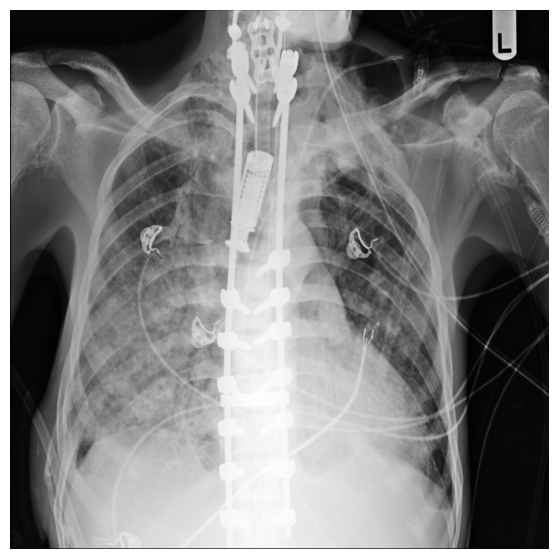

Image 25


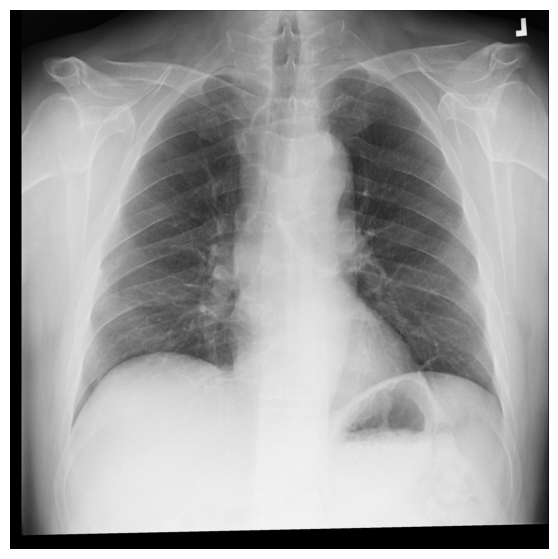

Image 118


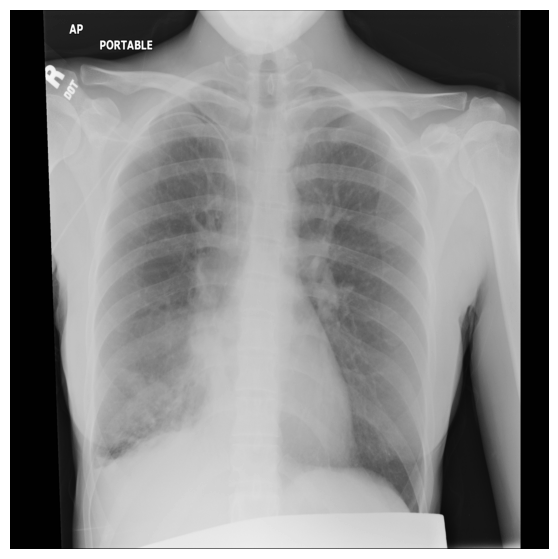

Image 174


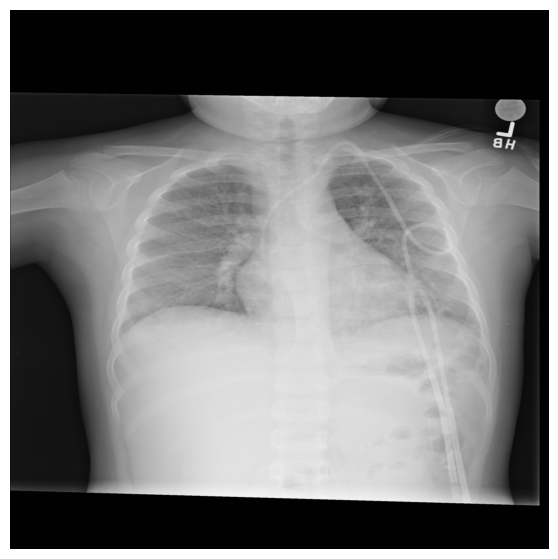

Image 106


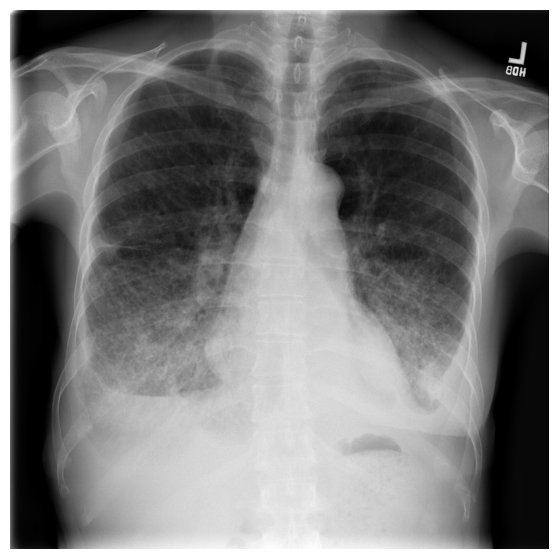

In [7]:
import random
max_index = len(df_labels["dicom_file"].values)
print('There are total of %s images. We will sample 5 to display.' % max_index)
list_of_images = random.sample(range(0, max_index-1), 5)

import io
import pydicom
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from cxr_foundation import constants
from cxr_foundation import example_generator_lib

file_to_visualize = 2

def show_dicom(adicom):
  """Shows the DICOM in a format as passed to CXR Foundation."""
  png_image_data = example.features.feature[
      constants.IMAGE_KEY].bytes_list.value[:][0]
  image = Image.open(io.BytesIO(png_image_data))
  figure_size=7
  f, axarr = plt.subplots(1, 1, figsize = (figure_size, figure_size))
  axarr.imshow(image, cmap='gray')
  axarr.axis('off')
  plt.show()

for image_idx in list_of_images:
  dicom = pydicom.read_file(df_labels["dicom_file"].values[image_idx])
  example = example_generator_lib.dicom_to_tfexample(dicom)
  print('Image %d' % image_idx)
  show_dicom(example)

In [8]:
import logging

from cxr_foundation.inference import generate_embeddings, InputFileType, OutputFileType


logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Generate and store a few embeddings in .npz format
generate_embeddings(input_files=df_labels["dicom_file"].values[:5], output_dir=EMBEDDINGS_DIR,
    input_type=InputFileType.DICOM, output_type=OutputFileType.NPZ)

INFO:root:Successfully generated ./data/outputs/00026260_000.npz
INFO:root:Successfully generated ./data/outputs/00026587_000.npz
INFO:root:Successfully generated ./data/outputs/00022115_000.npz
INFO:root:Successfully generated ./data/outputs/00008972_002.npz
INFO:root:Successfully generated ./data/outputs/00027108_012.npz


In [9]:
from cxr_foundation import embeddings_data

# Read the data from a generated .npz embeddings file.
filename = df_labels["embedding_file"][0].replace("tfrecord", "npz")
values = embeddings_data.read_npz_values(filename)

print(values)

# NOTE: The rest of the notebook will use the .tfrecord data

[ 0.04575907 -2.218638    0.5554486  ... -0.929538    0.97226554
 -0.4856232 ]


In [10]:
# Generate all the embedings in .tfrecord format
generate_embeddings(input_files=df_labels["dicom_file"].values, output_dir=EMBEDDINGS_DIR,
    input_type=InputFileType.DICOM, output_type=OutputFileType.TFRECORD)

INFO:root:Successfully generated ./data/outputs/00026260_000.tfrecord
INFO:root:Successfully generated ./data/outputs/00026587_000.tfrecord
INFO:root:Successfully generated ./data/outputs/00022115_000.tfrecord
INFO:root:Successfully generated ./data/outputs/00008972_002.tfrecord
INFO:root:Successfully generated ./data/outputs/00027108_012.tfrecord
INFO:root:Successfully generated ./data/outputs/00005216_010.tfrecord
INFO:root:Successfully generated ./data/outputs/00022852_000.tfrecord
INFO:root:Successfully generated ./data/outputs/00018808_000.tfrecord
INFO:root:Successfully generated ./data/outputs/00028987_001.tfrecord
INFO:root:Successfully generated ./data/outputs/00006582_000.tfrecord
INFO:root:Successfully generated ./data/outputs/00020339_004.tfrecord
INFO:root:Successfully generated ./data/outputs/00016919_010.tfrecord
INFO:root:Successfully generated ./data/outputs/00025232_000.tfrecord
INFO:root:Successfully generated ./data/outputs/00000857_008.tfrecord
INFO:root:Successful

In [11]:
# Inspect a tfrecord embedding file. A single file is only several kbs.
filename = df_labels["embedding_file"][0]

# Read the tf.train.Example object from the first tfrecord file
example = embeddings_data.read_tfrecord_example(filename)
print(example)

# If you don't care about the structure of the .tfrecord file, and/or if
# you don't use Tensorflow, you can use the following function to read
# the values directly into a numpy array.
values = embeddings_data.read_tfrecord_values(filename)
print(values)

features {
  feature {
    key: "embedding"
    value {
      float_list {
        value: 0.04575797915458679
        value: -2.2186379432678223
        value: 0.5554482936859131
        value: -0.7702878713607788
        value: -0.16220080852508545
        value: 1.0240060091018677
        value: 0.486133337020874
        value: -0.14355777204036713
        value: 1.1664481163024902
        value: 1.9681150913238525
        value: 0.6266320943832397
        value: 1.032698154449463
        value: 0.5547095537185669
        value: 0.23833589255809784
        value: 1.7112627029418945
        value: 1.3297978639602661
        value: 0.3516295254230499
        value: 1.982785940170288
        value: 0.08771675825119019
        value: 0.6659134030342102
        value: 3.270231246948242
        value: 1.8084502220153809
        value: -1.9195425510406494
        value: 1.1649662256240845
        value: -1.2261462211608887
        value: 0.09928584098815918
        value: -2.180789947509765

# Prepare Data for Model Training

Separate into training, validation, and testing sets.

In [12]:
from sklearn.model_selection import train_test_split


df_train, df_validate = train_test_split(df_labels, test_size=0.1)

# Train A Model

Finally, we can train a model using the embeddings! With a simple feed-forward neural network, it should take < 5 minutes to train 100 epochs! No GPU required.

In [13]:
import tensorflow as tf
import tensorflow_models as tfm


def create_model(heads,
                 embeddings_size=1376,
                 learning_rate=0.1,
                 end_lr_factor=1.0,
                 dropout=0.0,
                 decay_steps=1000,
                 loss_weights=None,
                 hidden_layer_sizes=[512, 256],
                 weight_decay=0.0,
                 seed=None) -> tf.keras.Model:
  """
  Creates linear probe or multilayer perceptron using LARS + cosine decay.


  """
  inputs = tf.keras.Input(shape=(embeddings_size,))
  hidden = inputs
  # If no hidden_layer_sizes are provided, model will be a linear probe.
  for size in hidden_layer_sizes:
    hidden = tf.keras.layers.Dense(
        size,
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
        kernel_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
        bias_regularizer=tf.keras.regularizers.l2(l2=weight_decay))(
            hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(dropout, seed=seed)(hidden)
  output = tf.keras.layers.Dense(
      units=len(heads),
      activation='sigmoid',
      kernel_initializer=tf.keras.initializers.HeUniform(seed=seed))(
          hidden)

  outputs = {}
  for i, head in enumerate(heads):
    outputs[head] = tf.keras.layers.Lambda(
        lambda x: x[..., i:i + 1], name=head.lower())(
            output)

  model = tf.keras.Model(inputs, outputs)
  learning_rate_fn = tf.keras.experimental.CosineDecay(
      tf.cast(learning_rate, tf.float32),
      tf.cast(decay_steps, tf.float32),
      alpha=tf.cast(end_lr_factor, tf.float32))
  model.compile(
      optimizer=tfm.optimization.lars.LARS(
          learning_rate=learning_rate_fn),
      loss=dict([(head, 'binary_crossentropy') for head in heads]),
      loss_weights=loss_weights or dict([(head, 1.) for head in heads]),
      weighted_metrics=[
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.AUC(curve='PR', name='auc_pr')])
  return model

In [14]:
# Create training and validation Datasets
training_data = embeddings_data.get_dataset(filenames=df_train["embedding_file"].values,
                        labels=df_train[DIAGNOSIS].values)


validation_data = embeddings_data.get_dataset(filenames=df_validate["embedding_file"].values,
                        labels=df_validate[DIAGNOSIS].values)

# Create and train the model
model = create_model([DIAGNOSIS])

model.fit(
    x=training_data.batch(512).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data.batch(1).cache(),
    epochs=100,
)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.6733 - false_positives: 32.0000 - false_negatives: 31.0000 - true_positives: 59.0000 - true_negatives: 58.0000 - auc: 0.6991 - auc_pr: 0.6806 - val_loss: 0.8388 - val_false_positives: 0.0000e+00 - val_false_negatives: 8.0000 - val_true_positives: 2.0000 - val_true_negatives: 10.0000 - val_auc: 0.6800 - val_auc_pr: 0.7574
Epoch 2/100
1/1 [==============================] - 0s 107ms/step - loss: 0.6510 - false_positives: 30.0000 - false_negatives: 31.0000 - true_positives: 59.0000 - true_negatives: 60.0000 - auc: 0.7180 - auc_pr: 0.7008 - val_loss: 0.8254 - val_false_positives: 0.0000e+00 - val_false_negatives: 8.0000 - val_true_positives: 2.0000 - val_true_negatives: 10.0000 - val_auc: 0.6750 - val_auc_pr: 0.7555
Epoch 3/100
1/1 [==============================] - 0s 114ms/step - loss: 0.6113 - false_positives: 29.0000 - false_negatives: 27.0000 - true_positives: 63.0000 - true_negatives: 61.0000 - auc: 0.7534 - auc_p

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1376)]            0         
                                                                 
 dense (Dense)               (None, 512)               705024    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                            

# Examine metrics

In [16]:
import sklearn
import matplotlib.pyplot as plt


def plot_curve(x, y, auc, x_label=None, y_label=None, label=None):
  fig = plt.figure(figsize=(10, 10))
  plt.plot(x, y, label=f'{label} (AUC: %.3f)' % auc, color='black')
  plt.legend(loc='lower right', fontsize=18)
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  if x_label:
    plt.xlabel(x_label, fontsize=24)
  if y_label:
    plt.ylabel(y_label, fontsize=24)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(visible=True)

In [17]:
rows = []
for embeddings, label in validation_data.batch(1):
  row = {
      f'{DIAGNOSIS}_prediction': model(embeddings)[DIAGNOSIS].numpy().flatten()[0],
      f'{DIAGNOSIS}_value': label.numpy().flatten()[0]
  }
  rows.append(row)
eval_df = pd.DataFrame(rows)

In [18]:
eval_df.head()

,AIRSPACE_OPACITY_prediction,AIRSPACE_OPACITY_value
0,0.941537,1.0
1,0.143761,1.0
2,0.999939,1.0
3,0.039469,0.0
4,0.000020,0.0


In [19]:
labels = eval_df[f'{DIAGNOSIS}_value'].values
predictions = eval_df[f'{DIAGNOSIS}_prediction'].values
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(
    labels,
    predictions,
    drop_intermediate=False)
auc = sklearn.metrics.roc_auc_score(labels, predictions)
plot_curve(false_positive_rate, true_positive_rate, auc, x_label='False Positive Rate', y_label='True Positive Rate', label=DIAGNOSIS)